In [1]:
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import ExtraTreesRegressor, RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn import preprocessing
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split
from sklearn import metrics
import seaborn as sns
from scipy import stats
from sklearn.preprocessing import StandardScaler

In [2]:
import argparse
import datetime
import os
import re
os.environ.setdefault("TF_CPP_MIN_LOG_LEVEL", "2")  # Report only TF errors by default

'2'

In [3]:
import tensorflow as tf
import tensorflow_addons as tfa
from tensorflow import keras
import typing
if typing.TYPE_CHECKING:
    from keras.api._v2 import keras

/home/masekda4/anaconda3/envs/toml/lib/python3.11/site-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


# Simple NN

In [4]:
seed = 42
# Load the CSV file
data = pd.read_csv("BC-Data-Set.csv")
# Convert the date column to a datetime object
data['date'] = pd.to_datetime(data['date'])

# Remove any missing values
data = data.dropna()

# Set the date column as the index of the DataFrame
data = data.set_index('date')
x_train, x_test, y_train, y_test = train_test_split(data, data.BC, test_size=0.15, random_state=seed, shuffle=True)
x_train = x_train.drop(columns=['BC'])
x_test = x_test.drop(columns=['BC'])

SCALE = True
if SCALE:
    scaler = StandardScaler()
    x_train = scaler.fit_transform(x_train)
    x_test = scaler.transform(x_test)

In [24]:
HIDDEN_SIZE = 32
batch_size = 256

x = keras.Input([x_train.shape[-1]])
y = keras.layers.Dense(HIDDEN_SIZE, activation=keras.activations.relu)(x)
y = keras.layers.Dense(HIDDEN_SIZE, activation=keras.activations.relu)(y)
y = keras.layers.Dense(1, activation=None)(y)

model = keras.Model(inputs=x, outputs=y)

model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=1e-3),
        loss=keras.losses.mean_squared_error,
        metrics=[tfa.metrics.RSquare()],
    )

In [25]:
model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 12)]              0         
                                                                 
 dense_6 (Dense)             (None, 32)                416       
                                                                 
 dense_7 (Dense)             (None, 32)                1056      
                                                                 
 dense_8 (Dense)             (None, 1)                 33        
                                                                 
Total params: 1,505
Trainable params: 1,505
Non-trainable params: 0
_________________________________________________________________


In [26]:
history = model.fit(
    x = x_train,
    y = y_train,
    batch_size = batch_size,
    epochs = 500,
    validation_split=0.15,
    callbacks = [
        tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', patience=20, restore_best_weights=True),
        # tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', mode='min', patience=10, factor=0.1, min_lr=1e-5)
    ]
)

Epoch 1/500
12/12 [==============================] - 2s 23ms/step - loss: 1.4465 - r_square: -0.1511 - val_loss: 1.3219 - val_r_square: 0.0621
Epoch 2/500
12/12 [==============================] - 0s 10ms/step - loss: 1.0419 - r_square: 0.1708 - val_loss: 1.1412 - val_r_square: 0.1903
Epoch 3/500
12/12 [==============================] - 0s 11ms/step - loss: 0.8790 - r_square: 0.3005 - val_loss: 0.9449 - val_r_square: 0.3296
Epoch 4/500
12/12 [==============================] - 0s 10ms/step - loss: 0.7515 - r_square: 0.4020 - val_loss: 0.8002 - val_r_square: 0.4323
Epoch 5/500
12/12 [==============================] - 0s 12ms/step - loss: 0.6589 - r_square: 0.4756 - val_loss: 0.6756 - val_r_square: 0.5207
Epoch 6/500
12/12 [==============================] - 0s 10ms/step - loss: 0.5923 - r_square: 0.5286 - val_loss: 0.5847 - val_r_square: 0.5852
Epoch 7/500
12/12 [==============================] - 0s 11ms/step - loss: 0.5403 - r_square: 0.5701 - val_loss: 0.5399 - val_r_square: 0.6170
Epoch

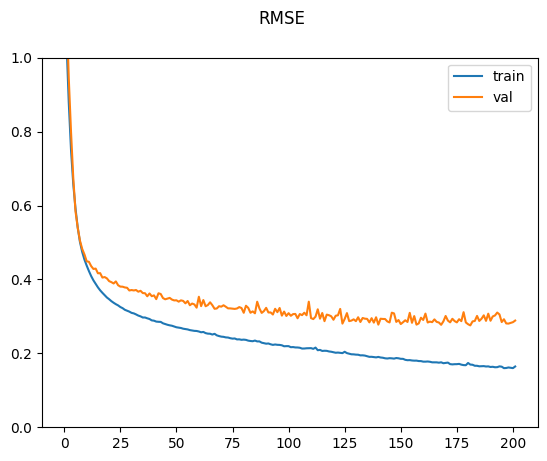

In [27]:
plt.ylim(0, 1)
plt.suptitle(f'RMSE')
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='val')
plt.legend()
plt.show()

In [31]:
val_rmse = min(history.history['val_loss'])
val_rmse

0.2756626605987549

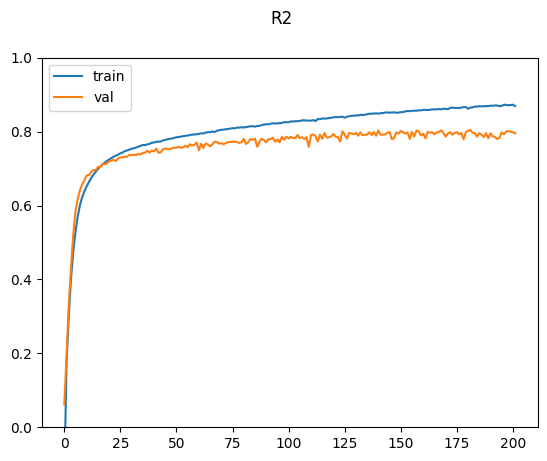

In [32]:
plt.suptitle(f'R2')
plt.plot(history.history['r_square'], label='train')
plt.plot(history.history['val_r_square'], label='val')
plt.ylim(0, 1)
plt.legend()
plt.show()

In [33]:
val_r2 = max(history.history['val_r_square'])
val_r2

0.804426372051239

Simple NN:
I can get much lower VAL RMSE and about the same R2 score. Lower batch size seems better but takes long time to run (and maybe we're just overfitting). Two layers of 32 or 64 give good results on DEV. 

Preprocessing effect: No large spikes at the begginng (which was to be expected actually). Probably better RMSE, R2 seems the same I guess.

Previous results:

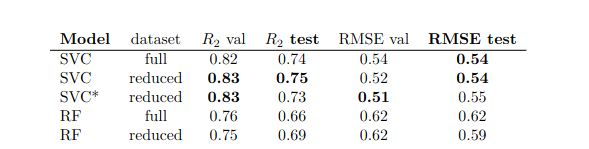

## Test

In [34]:
y_pred = model.predict(x_test, batch_size=256, verbose=1)
y_pred = y_pred.flatten()

3/3 [==============================] - 0s 2ms/step


In [35]:
test_rmse = keras.metrics.mean_squared_error(y_test, y_pred).numpy()
test_rmse = np.sqrt(test_rmse)
test_rmse

0.5337558

In [36]:
test_r2 = tfa.metrics.RSquare()(y_test, y_pred).numpy()
test_r2

0.75057995

In [37]:
val_rmse, test_rmse

(0.2756626605987549, 0.5337558)

In [38]:
val_r2, test_r2

(0.804426372051239, 0.75057995)

# LSTM

In [39]:
seed = 42
# Load the CSV file
data = pd.read_csv("BC-Data-Set.csv")
# Convert the date column to a datetime object
data['date'] = pd.to_datetime(data['date'])

# Remove any missing values
data = data.dropna()

# Set the date column as the index of the DataFrame
data = data.set_index('date')

In [40]:
train_len = round(len(data) * 0.85)

In [41]:
x_train_raw = data.iloc[:train_len].drop(columns=['BC'])
x_train_idx = x_train_raw.index
y_train_raw = data.iloc[:train_len]['BC']
x_test_raw = data.iloc[train_len:].drop(columns=['BC'])
x_test_idx = x_test_raw.index
y_test_raw = data.iloc[train_len:]['BC']


SCALE = True
if SCALE:
    scaler = StandardScaler()
    # this returns numpy array
    x_train_raw = scaler.fit_transform(x_train_raw)
    x_train_raw = pd.DataFrame(x_train_raw, columns=scaler.get_feature_names_out())
    x_train_raw = x_train_raw.set_index(x_train_idx)
    x_test_raw = pd.DataFrame(scaler.transform(x_test_raw), columns=scaler.get_feature_names_out())
    x_test_raw = x_test_raw.set_index(x_test_idx)

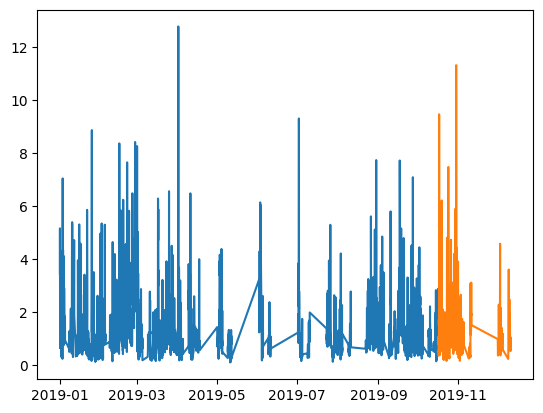

In [42]:
plt.plot(y_train_raw)
plt.plot(y_test_raw)

In [43]:
from tqdm import tqdm

In [44]:
def build_dataset(x_raw, y_raw, window_len = 24):
    X_time = []
    if SCALE:
        mean_row = np.zeros_like(x_raw.mean())
    else:
        mean_row = x_raw.mean().values
    # y_time = []
    for index, row in tqdm(x_raw.iterrows()):
        x = []
        y = []
        # starts from 0 to include current
        for dt in range(window_len):
            prev_idx = index - pd.Timedelta(hours=dt)
            if prev_idx in x_raw.index:
                prev = x_raw.loc[prev_idx]
                # prev_y = y_raw.loc[prev_idx]
            else:
                prev = mean_row.copy()
            x.append(prev)
            # y.append(prev_y)
        x.reverse()
        y.reverse()
        X_time.append(x)
        # y_time.append(y)
    return np.array(X_time), np.array(y_raw)

In [45]:
x_train, y_train = build_dataset(x_train_raw, y_train_raw)

3590it [00:06, 553.22it/s]


In [46]:
x_train = np.array(x_train)
x_train.shape

(3590, 24, 12)

In [52]:
HIDDEN_SIZE = 32
batch_size = 32

x = keras.Input(x_train.shape[1:])
y = keras.layers.LSTM(HIDDEN_SIZE, return_sequences=False)(x)
y = keras.layers.Dense(1, activation=None)(y)

model = keras.Model(inputs=x, outputs=y)

model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=1e-3),
        loss=keras.losses.mean_squared_error,
        metrics=[tfa.metrics.RSquare()],
    )

model.summary()

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 24, 12)]          0         
                                                                 
 lstm_1 (LSTM)               (None, 32)                5760      
                                                                 
 dense_10 (Dense)            (None, 1)                 33        
                                                                 
Total params: 5,793
Trainable params: 5,793
Non-trainable params: 0
_________________________________________________________________


In [53]:
history = model.fit(
    x = x_train,
    y = y_train,
    batch_size = batch_size,
    epochs = 500,
    validation_split=0.15,
    shuffle=True,
    callbacks = [
        # tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', patience=20, restore_best_weights=True),
        tf.keras.callbacks.EarlyStopping(monitor='val_r_square', mode='max', patience=20, restore_best_weights=True),
        # tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', mode='min', patience=10, factor=0.1, min_lr=1e-5)
    ]
)

Epoch 1/500
96/96 [==============================] - 3s 12ms/step - loss: 1.1048 - r_square: 0.1446 - val_loss: 0.5216 - val_r_square: 0.3361
Epoch 2/500
96/96 [==============================] - 1s 7ms/step - loss: 0.6048 - r_square: 0.5317 - val_loss: 0.4527 - val_r_square: 0.4239
Epoch 3/500
96/96 [==============================] - 1s 7ms/step - loss: 0.4706 - r_square: 0.6356 - val_loss: 0.4036 - val_r_square: 0.4863
Epoch 4/500
96/96 [==============================] - 1s 7ms/step - loss: 0.3853 - r_square: 0.7016 - val_loss: 0.3870 - val_r_square: 0.5075
Epoch 5/500
96/96 [==============================] - 1s 7ms/step - loss: 0.3287 - r_square: 0.7455 - val_loss: 0.3611 - val_r_square: 0.5404
Epoch 6/500
96/96 [==============================] - 1s 7ms/step - loss: 0.2919 - r_square: 0.7740 - val_loss: 0.3646 - val_r_square: 0.5359
Epoch 7/500
96/96 [==============================] - 1s 7ms/step - loss: 0.2675 - r_square: 0.7929 - val_loss: 0.3325 - val_r_square: 0.5768
Epoch 8/500


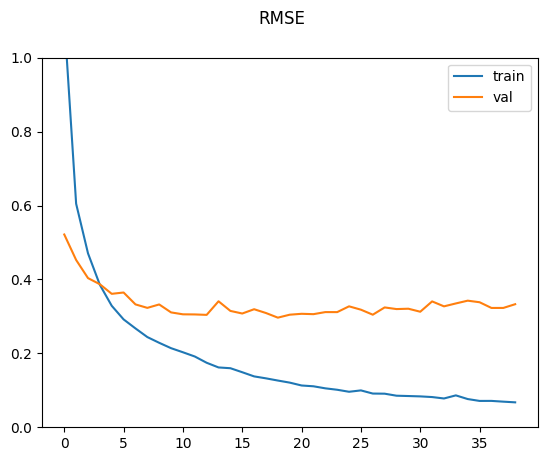

In [54]:
plt.ylim(0, 1)
plt.suptitle(f'RMSE')
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='val')
plt.legend()
plt.show()

In [55]:
val_rmse = min(history.history['val_loss'])
val_rmse

0.2966032922267914

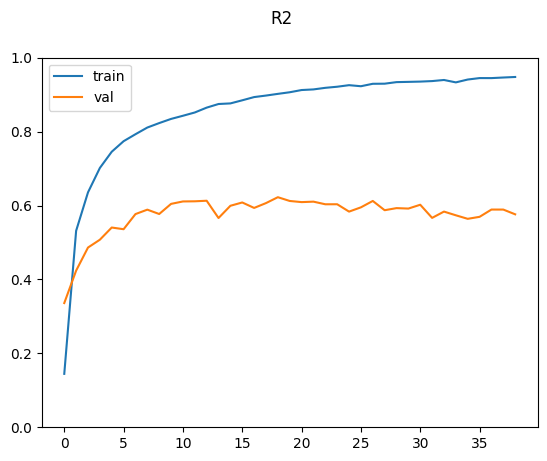

In [56]:
plt.suptitle(f'R2')
plt.plot(history.history['r_square'], label='train')
plt.plot(history.history['val_r_square'], label='val')
plt.ylim(0, 1)
plt.legend()
plt.show()

In [57]:
val_r2 = max(history.history['val_r_square'])
val_r2

0.6224921345710754

## Test

In [58]:
x_test, y_test = build_dataset(x_test_raw, y_test_raw)
x_test.shape

633it [00:00, 789.94it/s]


(633, 24, 12)

In [59]:
y_pred = model.predict(x_test, batch_size=256, verbose=1)
y_pred = y_pred.flatten()

3/3 [==============================] - 0s 2ms/step


In [60]:
test_rmse = keras.metrics.mean_squared_error(y_test, y_pred).numpy()
test_rmse = np.sqrt(test_rmse)
test_rmse

0.7457489

In [61]:
test_r2 = tfa.metrics.RSquare()(y_test, y_pred).numpy()
test_r2

0.6295601

In [62]:
val_rmse, test_rmse

(0.2756626605987549, 0.5337558)

In [63]:
val_r2, test_r2

(0.804426372051239, 0.75057995)